In [1]:
import sys
sys.path.append('../src/')
import math

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_experiment(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    columns = ['train_BA', 'train_auroc', 'val_BA', 'val_auroc', 'test_BA', 'test_auroc']
    for column in columns:
        df[column] = df[column].apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    return df

def split_df(df, index):
    X_train = torch.Tensor(df[df.n<=360]['n'].to_numpy())
    y_train = torch.Tensor(np.array(df[df.n<=360]['test_auroc'].to_list())[:,index])
    X_test = torch.Tensor(df[df.n>360]['n'].to_numpy())
    y_test = torch.Tensor(np.array(df[df.n>360]['test_auroc'].to_list())[:,index])
    return X_train, y_train, X_test, y_test

In [3]:
class power_law(nn.Module):
    def __init__(self):
        super().__init__()
        self.epsilon = 0.0
        self.theta1 = torch.nn.Parameter(torch.tensor([0.0]))
        self.theta2 = torch.nn.Parameter(torch.tensor([0.0]))
        self.softplus = torch.nn.Softplus()

    def forward(self, x):
        theta1 = self.softplus(self.theta1)
        theta2 = torch.sigmoid(self.theta2)
        return (1.0 - self.epsilon) - (theta1 * torch.pow(x, theta2)).ravel()
    
def train_power_law(X, y, training_iter=100000):
    model = power_law()
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = nn.MSELoss()
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(X)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
    return model

A review of [Jain et al.'s (2023)](https://arxiv.org/abs/2303.01598) prediction model for our setting (not few-shot setting).

They define

\begin{align}
1-\hat{v}(n_i) &= \theta_1 n^{\theta_2} \\
\hat{v}(n) &= 1 - \theta_1 n^{\theta_2}
\end{align}

and

\begin{align}
\hat{y}_i &= \log(1-\hat{v}(n_i)) \\
&= \log(1 - (1 - \theta_1 n^{\theta_2})) \\
&= \log(1 - 1 + \theta_1 n^{\theta_2}) \\
&= \log(\theta_1) + \theta_2\log(n).
\end{align}

Then they represent their model in the form

\begin{align}
\alpha(x) &= [1, \log(n)] \\
\theta &= [\log(\theta_1), \theta_2]^T.
\end{align}

Note: both $\alpha$ and $\theta$ should be bold.

They define

\begin{align}
\Sigma_\theta = (J^TJ)^{-1}, J = \left[ \frac{\partial \mathbf{\hat{y}}}{\partial \theta} \right]
\end{align}


where $J \in \mathcal{R}^{m\times2}$, $m$ is the number of training samples, and

\begin{align}
\frac{\partial \mathbf{\hat{y}}}{\partial \theta_1} &= \frac{1}{\theta_1} \\
\frac{\partial \mathbf{\hat{y}}}{\partial \theta_2} &= \log(n).
\end{align}

They define the mean and variance for the log domain as

\begin{align}
\mu_{\hat{y}}(n) &= \hat{y} \\
\sigma^2_{\hat{y}}(n) &= \alpha^T(n)\Sigma_\theta\alpha(n).
\end{align}

In [4]:
# ChestX-ray14 (long range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_long_range.csv')
df = df.groupby('n').agg(lambda x: list(x))
df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
df.random_state = df.random_state.apply(lambda x: 'mean')
df = df.reset_index()
df.head()

,n,random_state,train_BA,train_auroc,val_BA,val_auroc,test_BA,test_auroc
0,200,mean,"[[0.79979571, 0.73333333, 0.73013219], [0.8212...","[[0.81154239, 0.79803922, 0.787068], [0.872838...","[[0.63507077, 0.67985708, 0.54648319], [0.6245...","[[0.66493573, 0.73191571, 0.55944552], [0.6650...","[[0.65107024, 0.69175081, 0.55387147], [0.6484...","[0.6858934266666666, 0.73942905, 0.59523719]"
1,240,mean,"[[0.76419842, 0.72886922, 0.703125], [0.780733...","[[0.79834651, 0.77641348, 0.76475694], [0.8513...","[[0.63221494, 0.67773304, 0.56368396], [0.6325...","[[0.66143413, 0.72811977, 0.5764621], [0.66903...","[[0.64416552, 0.68318055, 0.56370069], [0.6441...","[0.6810822633333333, 0.7379454033333334, 0.600..."
2,280,mean,"[[0.76189431, 0.73673674, 0.68069986], [0.7611...","[[0.78875714, 0.78656434, 0.75529881], [0.8432...","[[0.63441532, 0.68058398, 0.5519029], [0.63858...","[[0.66500938, 0.73349715, 0.56759572], [0.6778...","[[0.64824932, 0.68792408, 0.56802236], [0.6514...","[0.6881680066666668, 0.7443241866666667, 0.600..."
3,320,mean,"[[0.73260479, 0.75357143, 0.67634027], [0.7671...","[[0.78587266, 0.79214286, 0.73871764], [0.8453...","[[0.63399048, 0.67859005, 0.57828413], [0.6385...","[[0.66374208, 0.73379837, 0.60318726], [0.6781...","[[0.64981552, 0.68217625, 0.58400504], [0.6465...","[0.6842838533333334, 0.7463586633333333, 0.609..."
4,360,mean,"[[0.74019287, 0.73516129, 0.66513963], [0.7559...","[[0.78228179, 0.77954839, 0.71704274], [0.8318...","[[0.6297232, 0.67233627, 0.58974225], [0.64571...","[[0.6610841, 0.72788237, 0.6147395], [0.685054...","[[0.6389557, 0.67894272, 0.59206388], [0.65201...","[0.6880869333333334, 0.7448506900000001, 0.616..."


In [5]:
index = 0
X_train, y_train, X_test, y_test = split_df(df, index=index)
model = train_power_law(X_train, y_train)
model.eval()

power_law(
  (softplus): Softplus(beta=1, threshold=20)
)

In [10]:
theta1, theta2 = [p for p in model.parameters()]
theta1, theta2 = model.softplus(theta1).item(), torch.sigmoid(theta2).item()
thetas = np.array([[np.log(theta1)], [theta2]])

J = np.array([[1/theta1, np.log(x)] for x in X_train.detach().numpy()])
Sigma = np.linalg.inv(J.T@J)

print('Thetas:\n{}\n'.format(thetas))
print('J:\n{}\n'.format(J))
print('Sigma:\n{}\n'.format(Sigma))

Thetas:
[[-1.15679336e+00]
 [ 1.62080607e-06]]

J:
[[3.1797207  5.29831743]
 [3.1797207  5.48063898]
 [3.1797207  5.63478947]
 [3.1797207  5.76832104]
 [3.1797207  5.88610411]]

Sigma:
[[14.4676618  -8.18368698]
 [-8.18368698  4.63547107]]



In [13]:
import scipy
from scipy.stats import norm, lognorm

alphas = np.array([[[1], [np.log(x)]] for x in np.linspace(200, 30000, 1000)])
y_means = np.array([alpha.T@thetas for alpha in alphas]).ravel()
y_sigmas = np.array([alpha.T@Sigma@alpha for alpha in alphas]).ravel()

v_means = 1-np.exp(y_means+y_sigmas/2)
v_sigmas = np.exp(y_means+y_sigmas/2)*np.sqrt(np.exp(y_sigmas-1))

sigmas = [lognorm(s=np.sqrt(v_sigma), loc=v_mean).std() for v_mean, v_sigma in zip(v_means, v_sigmas)]
means = [lognorm(s=np.sqrt(v_sigma), loc=v_mean).mean() for v_mean, v_sigma in zip(v_means, v_sigmas)]
#lowers = [lognorm(s=np.sqrt(v_sigma), loc=v_mean).ppf(0.025) for v_mean, v_sigma in zip(v_means, v_sigmas)]
#uppers = [lognorm(s=np.sqrt(v_sigma), loc=v_mean).ppf(0.975) for v_mean, v_sigma in zip(v_means, v_sigmas)]

#uppers = 1-np.exp([scipy.stats.norm.ppf(0.05, loc=y_mean, scale=np.sqrt(y_sigma)) for y_mean, y_sigma in zip(y_means, y_sigmas)])
#means = 1-np.exp([scipy.stats.norm(loc=y_mean, scale=np.sqrt(y_sigma)).mean() for y_mean, y_sigma in zip(y_means, y_sigmas)])
#lowers = 1-np.exp([scipy.stats.norm.ppf(0.6, loc=y_mean, scale=np.sqrt(y_sigma)) for y_mean, y_sigma in zip(y_means, y_sigmas)])

In [30]:
1-np.exp(y_means)

array([0.68550427, 0.6855042 , 0.68550414, 0.68550408, 0.68550403,
       0.68550398, 0.68550394, 0.6855039 , 0.68550387, 0.68550384,
       0.6855038 , 0.68550377, 0.68550375, 0.68550372, 0.68550369,
       0.68550367, 0.68550365, 0.68550363, 0.6855036 , 0.68550358,
       0.68550356, 0.68550355, 0.68550353, 0.68550351, 0.68550349,
       0.68550348, 0.68550346, 0.68550345, 0.68550343, 0.68550342,
       0.6855034 , 0.68550339, 0.68550338, 0.68550336, 0.68550335,
       0.68550334, 0.68550333, 0.68550331, 0.6855033 , 0.68550329,
       0.68550328, 0.68550327, 0.68550326, 0.68550325, 0.68550324,
       0.68550323, 0.68550322, 0.68550321, 0.6855032 , 0.68550319,
       0.68550318, 0.68550317, 0.68550316, 0.68550315, 0.68550315,
       0.68550314, 0.68550313, 0.68550312, 0.68550311, 0.68550311,
       0.6855031 , 0.68550309, 0.68550308, 0.68550308, 0.68550307,
       0.68550306, 0.68550305, 0.68550305, 0.68550304, 0.68550303,
       0.68550303, 0.68550302, 0.68550301, 0.68550301, 0.68550

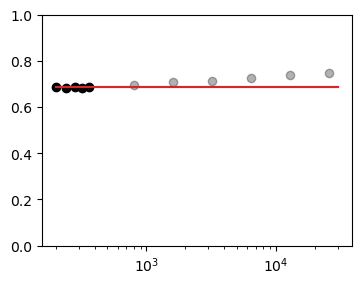

In [20]:
ncols = 1
nrows = 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
# Plot data
temp_df = df[df.random_state=='mean']
np.array(axs).flatten()[0]\
.scatter(temp_df[temp_df.n<=360].n.to_numpy(),
         np.array(temp_df[temp_df.n<=360].test_auroc.to_list())[:,index],
         color='black',
         alpha=1.0,
         label='Initial subsets')
np.array(axs).flatten()[0]\
.scatter(temp_df[temp_df.n>360].n.to_numpy(),
         np.array(temp_df[temp_df.n>360].test_auroc.to_list())[:,index],
         color='black',
         alpha=0.3,
         label='Ground truth')
np.array(axs).flatten()[0]\
        .plot(np.linspace(200, 30000, 1000), model(torch.linspace(200, 30000, 1000)).detach().numpy(), color='#1f77b4', label='Our model')
np.array(axs).flatten()[0]\
        .plot(np.linspace(200, 30000, 1000), 1-np.exp(y_means), color='#d62728', label='Power law')
#np.array(axs).flatten()[0]\
#        .fill_between(np.linspace(200, 30000, 1000), lowers, uppers, color='#d62728', alpha=0.3, label='Power law')
np.array(axs).flatten()[0]\
.set_ylim([0,1])
np.array(axs).flatten()[0]\
.set_xscale('log')
fig.show()